# **Import Needed Libraries**



In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as randomForestClassifier
from sklearn.svm import SVC # Import SVC

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **import data**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fake-and-real-news-dataset' dataset.
Path to dataset files: /kaggle/input/fake-and-real-news-dataset


# **Read Data**

In [3]:
true_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
fake_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

df = pd.concat([true_df, fake_df], ignore_index=True)
df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# **EDA**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


In [5]:
df.describe()

,title,text,subject,date
count,44898,44898,44898,44898
unique,38729,38646,8,2397
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017"
freq,14,627,11272,182


In [6]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [7]:
df['subject'].value_counts()

,count
subject,
politicsNews,11272
worldnews,10145
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


<Axes: xlabel='count', ylabel='subject'>

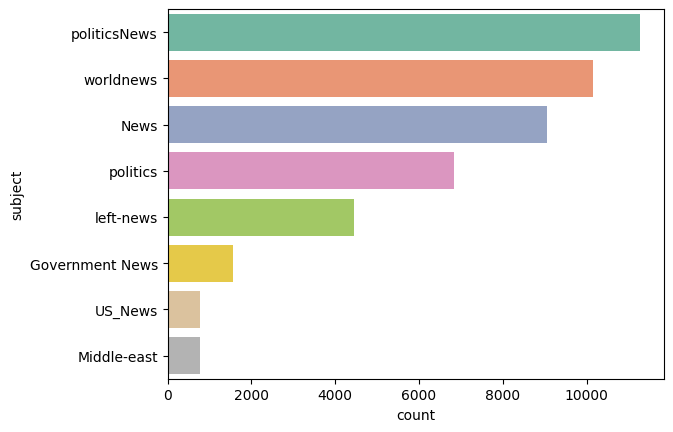

In [9]:
sns.countplot(df.subject, palette='Set2', order=df.subject.value_counts().index)

In [10]:
df.drop(columns=["title","date","subject"],inplace=
        True)
df

,text
0,WASHINGTON (Reuters) - The head of a conservat...
1,WASHINGTON (Reuters) - Transgender people will...
2,WASHINGTON (Reuters) - The special counsel inv...
3,WASHINGTON (Reuters) - Trump campaign adviser ...
4,SEATTLE/WASHINGTON (Reuters) - President Donal...
...,...
44893,21st Century Wire says As 21WIRE reported earl...
44894,21st Century Wire says It s a familiar theme. ...
44895,Patrick Henningsen 21st Century WireRemember ...
44896,21st Century Wire says Al Jazeera America will...


# **Text Preprocessing**

In [12]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        # Add movie-specific stop words
        self.stop_words.update(['movie', 'film', 'movies', 'films', 'watch', 'watched', 'see', 'saw'])
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Clean and preprocess text"""
        if isinstance(text, float):
            text = str(text)

        # Convert to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove URLs
        text = re.sub(r'http\S+', '', text)

        # Remove punctuation and numbers
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_lemmatize(self, text):
        """Tokenize and lemmatize text"""
        tokens = word_tokenize(text)

        # Remove stopwords and short tokens, then lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]

        return tokens

    def preprocess_dataset(self, df, text_column='text'):
        """Preprocess entire dataset"""
        print("Cleaning text...")
        df['cleaned_text'] = df[text_column].apply(self.clean_text)

        print("Tokenizing and lemmatizing...")
        df['tokens'] = df['cleaned_text'].apply(self.tokenize_and_lemmatize)

        df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

        return df

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Preprocess data
print("Preprocessing text data...")
df = preprocessor.preprocess_dataset(df)

print("\nPreprocessing completed!")
print(df[['text', 'cleaned_text', 'tokens']].head())

Preprocessing text data...
Cleaning text...
Tokenizing and lemmatizing...

Preprocessing completed!
                                                text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...   

                                        cleaned_text  \
0  washington reuters the head of a conservative ...   
1  washington reuters transgender people will be ...   
2  washington reuters the special counsel investi...   
3  washington reuters trump campaign adviser geor...   
4  seattle washington reuters president donald tr...   

                                              tokens  
0  [washington, reuters, head, conservative, repu...  
1  [washington, reuters, transgender, people, all...  
2  [washington, reuters, special, counsel, invest...  
3  [wa

In [13]:
df

,text,cleaned_text,tokens,processed_text
0,WASHINGTON (Reuters) - The head of a conservat...,washington reuters the head of a conservative ...,"[washington, reuters, head, conservative, repu...",washington reuters head conservative republica...
1,WASHINGTON (Reuters) - Transgender people will...,washington reuters transgender people will be ...,"[washington, reuters, transgender, people, all...",washington reuters transgender people allowed ...
2,WASHINGTON (Reuters) - The special counsel inv...,washington reuters the special counsel investi...,"[washington, reuters, special, counsel, invest...",washington reuters special counsel investigati...
3,WASHINGTON (Reuters) - Trump campaign adviser ...,washington reuters trump campaign adviser geor...,"[washington, reuters, trump, campaign, adviser...",washington reuters trump campaign adviser geor...
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,seattle washington reuters president donald tr...,"[seattle, washington, reuters, president, dona...",seattle washington reuters president donald tr...
...,...,...,...,...
44893,21st Century Wire says As 21WIRE reported earl...,st century wire says as wire reported earlier ...,"[century, wire, say, wire, reported, earlier, ...",century wire say wire reported earlier week un...
44894,21st Century Wire says It s a familiar theme. ...,st century wire says it s a familiar theme whe...,"[century, wire, say, familiar, theme, whenever...",century wire say familiar theme whenever dispu...
44895,Patrick Henningsen 21st Century WireRemember ...,patrick henningsen st century wireremember whe...,"[patrick, henningsen, century, wireremember, o...",patrick henningsen century wireremember obama ...
44896,21st Century Wire says Al Jazeera America will...,st century wire says al jazeera america will g...,"[century, wire, say, jazeera, america, history...",century wire say jazeera america history one b...


# **Train test split**

In [16]:
# Add a 'label' column to the dataframe (0 for true news, 1 for fake news)
df['label'] = [0] * len(true_df) + [1] * len(fake_df)

# Define X (features) and y (target)
X = df['processed_text']
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Convert text column to numeric vector**

In [19]:
TfidfVectorizer=TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_train_vec=TfidfVectorizer.fit_transform(X_train)
X_test_vec=TfidfVectorizer.transform(X_test)

# **Machine Learning Models**

# **1.Logistic Regression**

In [20]:
LR=LogisticRegression(random_state=42,max_iter=1000)


LR.fit(X_train_vec,y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [21]:
y_pred = LR.predict(X_test_vec)

In [22]:
print(accuracy_score(y_test, y_pred))

0.9869710467706013


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4284
           1       0.99      0.98      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# **2.SVM**

In [27]:
svm=SVC()



svm.fit(X_train_vec,y_train)

SVC()

In [28]:
y_pred = svm.predict(X_test_vec)

In [29]:
print(accuracy_score(y_test, y_pred))

0.9942093541202672


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# **3.Random Forest**

In [31]:
RF=randomForestClassifier()

RF.fit(X_train_vec,y_train)

RandomForestClassifier()

In [32]:
y_pred = RF.predict(X_test_vec)

In [33]:
print(f'ACCURACY: {RF.score(X_test_vec,y_test)}')

ACCURACY: 0.9979955456570155


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



# **SO the best model is Logistic Regression**